## Molecular dynamics application example

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pre-requirements" data-toc-modified-id="Pre-requirements-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pre-requirements</a></span><ul class="toc-item"><li><span><a href="#Import-dependencies" data-toc-modified-id="Import-dependencies-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import dependencies</a></span></li><li><span><a href="#Notebook-configuration" data-toc-modified-id="Notebook-configuration-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Notebook configuration</a></span></li><li><span><a href="#Package-configuration" data-toc-modified-id="Package-configuration-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Package configuration</a></span></li></ul></li><li><span><a href="#MD-showcase---Langerin" data-toc-modified-id="MD-showcase---Langerin-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>MD showcase - Langerin</a></span></li><li><span><a href="#Space-A" data-toc-modified-id="Space-A-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Space A</a></span><ul class="toc-item"><li><span><a href="#Clustering" data-toc-modified-id="Clustering-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Clustering</a></span></li><li><span><a href="#Coreset-MSM-estimation" data-toc-modified-id="Coreset-MSM-estimation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Coreset MSM estimation</a></span><ul class="toc-item"><li><span><a href="#(MSM-on-train-data-dt-=-10-ns)" data-toc-modified-id="(MSM-on-train-data-dt-=-10-ns)-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>(MSM on train data <em>dt</em> = 10 ns)</a></span></li></ul></li></ul></li><li><span><a href="#Space-B" data-toc-modified-id="Space-B-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Space B</a></span><ul class="toc-item"><li><span><a href="#Clustering" data-toc-modified-id="Clustering-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Clustering</a></span></li><li><span><a href="#Coreset-MSM-estimation" data-toc-modified-id="Coreset-MSM-estimation-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Coreset MSM estimation</a></span><ul class="toc-item"><li><span><a href="#(MSM-on-test-data-dt-=-0.1-ns)" data-toc-modified-id="(MSM-on-test-data-dt-=-0.1-ns)-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>(MSM on test data <em>dt</em> = 0.1 ns)</a></span></li></ul></li></ul></li></ul></div>

## Pre-requirements

### Import dependencies

In [1]:
# Primary imports
import importlib     # Only needed for module editing
import json
import pandas as pd  # Optional dependency
from pathlib import Path
import pprint
import sys
import time
import warnings
warnings.simplefilter("ignore")  # Surpress or enable warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import datasets  # For sklearn test data set creation
from sklearn.preprocessing import StandardScaler

# CNN clustering module
import cnnclustering.cnn as cnn    # CNN clustering
import cnnclustering.cmsm as cmsm  # Core-set MSM estimation
import pydpc

This notebook was created using Python 3.8.

In [2]:
# Version information
print(sys.version)

3.8.5 | packaged by conda-forge | (default, Aug 21 2020, 18:21:27) 
[GCC 7.5.0]


### Notebook configuration

We use `matplotlib` to create plots. A `"matplotlibrc"` file can be used to customise the appearance of the plots.

In [3]:
# Matplotlib configuration
mpl.rc_file(
    "../matplotlibrc",
    use_default_template=False
)

In [4]:
# Axis property defaults for the plots
ax_props = {
    "xlabel": None,
    "ylabel": None,
    "xlim": (-2.5, 2.5),
    "ylim": (-2.5, 2.5),
    "xticks": (),
    "yticks": (),
    "aspect": "equal"
}

# Line plot property defaults
line_props = {
    "linewidth": 0,
    "marker": '.',
}

### Package configuration

In [5]:
# Configuration file found?
cnn.settings.cfgfile  # If None, no file is provided

In [6]:
# Display default settings
cnn.settings.defaults

{'default_cnn_cutoff': '1',
 'default_cnn_offset': '0',
 'default_radius_cutoff': '1',
 'default_member_cutoff': '2',
 'default_fit_policy': 'conservative',
 'default_predict_policy': 'conservative',
 'float_precision': 'sp',
 'int_precision': 'sp'}

## MD showcase - Langerin

In [7]:
importlib.reload(cnn)

<module 'cnnclustering.cnn' from '/home/janjoswig/CNN/cnnclustering/cnn.py'>

Let's read in some "real world" data for this example. We will work with a 6D projection of a classical MD trajectory of the C-type lectin receptor langerin that was generated by the dimension reduction procedure TICA.

In [8]:
langerin = cnn.CNN(points=np.load("md_example/md_showcase_langerin.npy", allow_pickle=True))

After creating a `CNN` instance, we can print out basic information about the data. The projection comes in 116 parts of individual independent simulations. The number of data points in these parts is written out for the first 4 parts. In total we have about 2.6 million data points in this set representing 26 microseconds of simulation time at a sampling timestep of 10 picoseconds.

In [9]:
print(langerin)

CNN cluster object
--------------------------------------------------------------------------------
Alias :                         root
Hierachy level :                0

Data point shape :              Parts      - 116, [5571  4148  20851  99928 ...]
                                Points     - 2641593
                                Dimensions - 6

Distance matrix calculated :    None
Neighbourhoods calculated :     None
Density graph calculated :      None

Clustered :                     False
Children :                      False



Dealing with six data dimensions we can still visualise the data quite well.

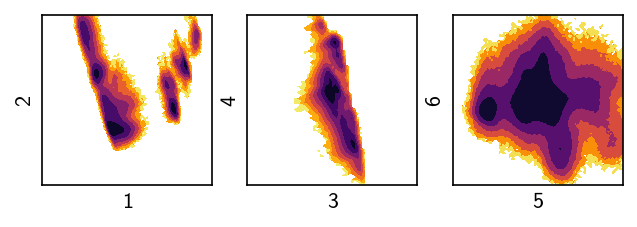

In [10]:
fig, Ax = plt.subplots(
    1, 3,
    figsize=(mpl.rcParams['figure.figsize'][0],
             mpl.rcParams['figure.figsize'][1]*0.5)
    )

for dim in range(3):
    dim_ = (dim * 2, dim * 2 + 1)
    ax_props_ = {k: v for k, v in ax_props.items()}
    ax_props_.update({"xlabel": dim_[0] + 1, "ylabel": dim_[1] + 1})
    _ = langerin.evaluate(
        ax=Ax[dim], plot="contourf",
        ax_props=ax_props_,
        dim=dim_
        )

Clustering of this fairly large amount of data points directly is in principle possible, but it will be slow. Pre-calculating pairwise distances would occupy terabytes of disk space which we can not afford and so we have resort to brute-force on-the-fly distance calculation. To allow quick and handy data exploration and cluster result screening we want to work on a reduced data set.

In [11]:
langerin_reduced = langerin.cut(points=(None, None, 100))

Now we distance pre-calculation is feasible and clustering will be much faster. When reducing a data set it is most important that the new set remains representative of the original one. Usually using a regular stride on the data points will be appropriate.

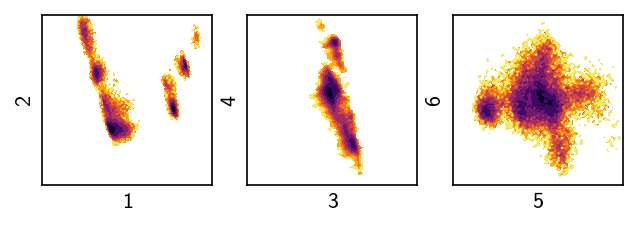

In [12]:
fig, Ax = plt.subplots(
    1, 3,
    figsize=(mpl.rcParams['figure.figsize'][0],
             mpl.rcParams['figure.figsize'][1]*0.5)
    )

for dim in range(3):
    dim_ = (dim * 2, dim * 2 + 1)
    ax_props_ = {k: v for k, v in ax_props.items()}
    ax_props_.update({"xlabel": dim_[0] + 1, "ylabel": dim_[1] + 1})
    _ = langerin_reduced.evaluate(
        ax=Ax[dim], plot="contourf",
        ax_props=ax_props_,
        dim=dim_
        )

In [13]:
print(langerin_reduced)

CNN cluster object
--------------------------------------------------------------------------------
Alias :                         root
Hierachy level :                0

Data point shape :              Parts      - 116, [56  42  209  1000 ...]
                                Points     - 26528
                                Dimensions - 6

Distance matrix calculated :    None
Neighbourhoods calculated :     None
Density graph calculated :      None

Clustered :                     False
Children :                      False



A quick look on the distribution of distances in the set gives us a first feeling for what might be a suitable value for the neighbour search radius *r*.

Mapping: 100%|██████████| 3.00/3.00 [00:12<00:00, 4.27s/Chunks]


(<Figure size 750x450 with 1 Axes>,
 <AxesSubplot:xlabel='d / au'>,
 None)

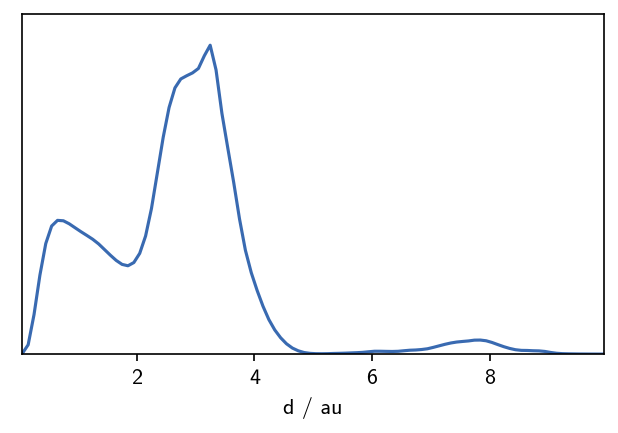

In [14]:
langerin_reduced.calc_dist(mmap=True, chunksize=5000)  # Pre-calculate point distances and temporary store on disk
langerin_reduced.dist_hist()

We can expect a split of the data into clusters for values of *r* of roughly 2 or lower. Let's attempt a first clustering step with a relatively low density criterion (large *r* cutoff, low number of common neighbours *c*):

In [15]:
langerin_reduced.fit(2, 5, policy="progressive")

Execution time for call of fit: 0 hours, 0 minutes, 24.7765 seconds
--------------------------------------------------------------------------------
#points   R         C         min       max       #clusters %largest  %noise    
26528     2.000     5         2         None      3         0.983     0.000     
--------------------------------------------------------------------------------


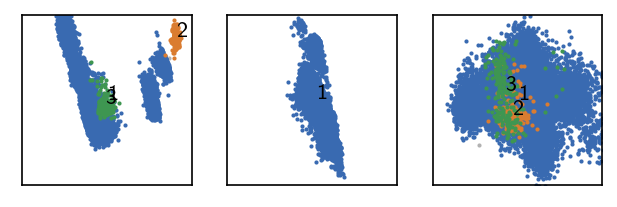

In [18]:
fig, Ax = plt.subplots(
    1, 3,
    figsize=(mpl.rcParams['figure.figsize'][0],
             mpl.rcParams['figure.figsize'][1]*0.5)
    )

for dim in range(3):
    _ = langerin_reduced.evaluate(
        ax=Ax[dim], plot="dots",
        ax_props=ax_props,
        dim=(dim * 2, dim * 2 + 1)
        )

We see that no data point was excluded as sparse outlier and we split the data into three clusters. Especially the first cluster can obviously be splitted further. Let' recluster it applying a higher density criterion. For this we first need to freeze this cluster result and isolate the obtained clusters into individual child cluster objects.

In [20]:
langerin_reduced.isolate()

In [22]:
# Recluster first cluster from last step
langerin_reduced.children[1].data.points.cKDTree()              # We pre-compute neighbourhoods here
langerin_reduced.children[1].calc_neighbours_from_cKDTree(r=1)
langerin_reduced.children[1].fit(1, 5)

Execution time for call of fit: 0 hours, 0 minutes, 3.4471 seconds
--------------------------------------------------------------------------------
#points   R         C         min       max       #clusters %largest  %noise    
26079     1.000     5         2         None      3         0.727     0.000     
--------------------------------------------------------------------------------


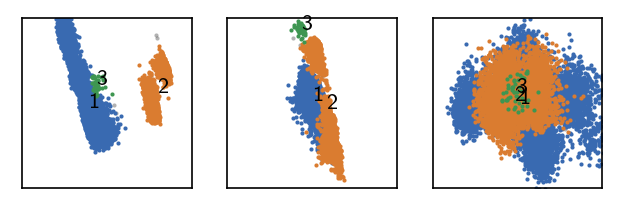

In [23]:
fig, Ax = plt.subplots(
    1, 3,
    figsize=(mpl.rcParams['figure.figsize'][0],
             mpl.rcParams['figure.figsize'][1]*0.5)
    )

for dim in range(3):
    _ = langerin_reduced.children[1].evaluate(
        ax=Ax[dim], plot="dots",
        ax_props=ax_props,
        dim=(dim * 2, dim * 2 + 1)
        )

The re-clustered data points are split into another three clusters. This time, we see an oportunity to again re-cluster the first two obtained clusters, slightly increasing the density criterion further.

In [39]:
langerin_reduced.children[1].isolate()

StopIteration: 

In [30]:
langerin_reduced.data.points.shape[0]

26528

In [40]:
langerin_reduced.data.points.edges.shape

(116,)

In [29]:
langerin_reduced.children[1].data.points.shape[0]

26079

In [41]:
langerin_reduced.children[1].data.points.edges.shape

(116,)

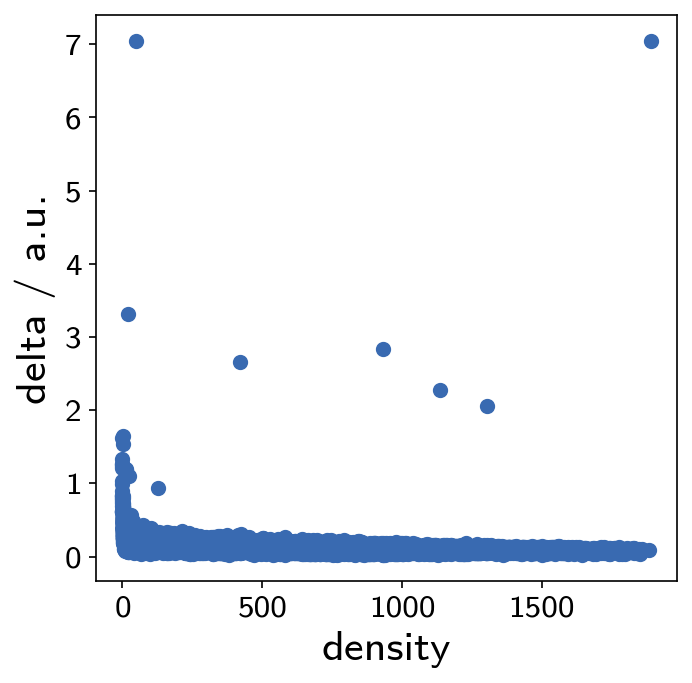

In [18]:
pydpc_clustering = pydpc.Cluster(np.asarray(langerin_reduced.data.points, order="c"))

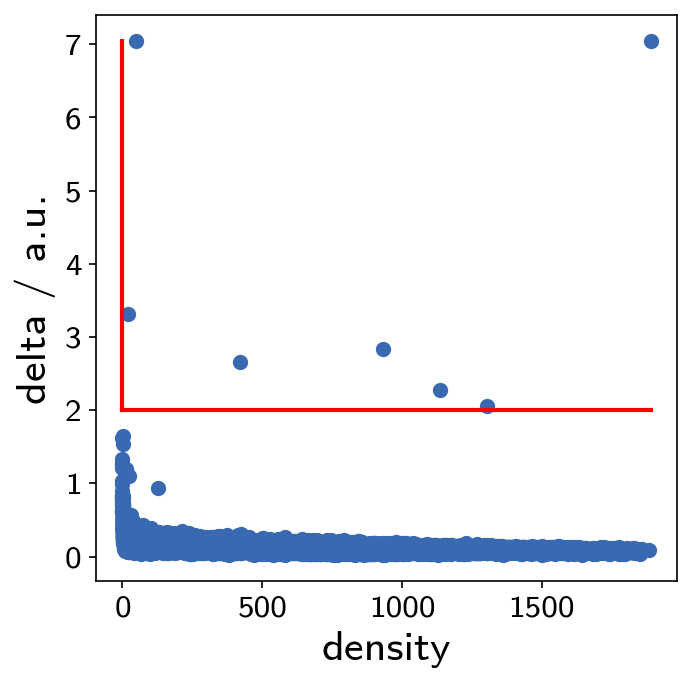

In [20]:
pydpc_clustering.assign(0, 2)

In [21]:
pydpc_clustering.clusters

array([  271,  5253,  5653,  6679,  7678, 22790, 24961], dtype=int32)

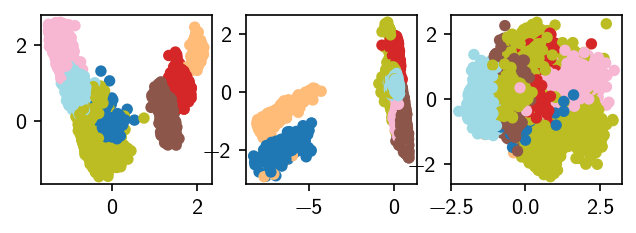

In [28]:
fig, Ax = plt.subplots(
    1, 3,
    figsize=(mpl.rcParams['figure.figsize'][0],
             mpl.rcParams['figure.figsize'][1]*0.5)
    )

for dim in range(3):
    Ax[dim].scatter(langerin_reduced.data.points[:, dim * 2], langerin_reduced.data.points[:, dim*2 + 1], s=20, c=pydpc_clustering.membership, cmap=mpl.cm.tab20)

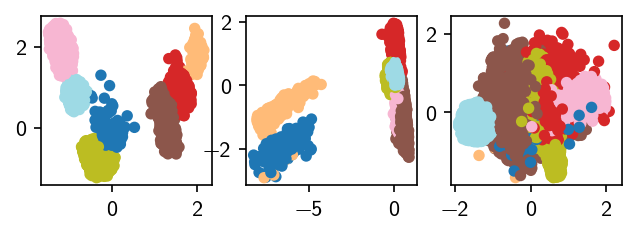

In [30]:
fig, Ax = plt.subplots(
    1, 3,
    figsize=(mpl.rcParams['figure.figsize'][0],
             mpl.rcParams['figure.figsize'][1]*0.5)
    )

for dim in range(3):
    Ax[dim].scatter(langerin_reduced.data.points[pydpc_clustering.core_idx, dim * 2],
                    langerin_reduced.data.points[pydpc_clustering.core_idx, dim*2 + 1],
                    s=20,
                    c=pydpc_clustering.membership[pydpc_clustering.core_idx],
                    cmap=mpl.cm.tab20)

In [33]:
langerin_reduced.labels = cnn.Labels(pydpc_clustering.membership)

In [35]:
langerin_reduced.labels[pydpc_clustering.halo_idx] = 0

In [36]:
M = cmsm.CMSM(langerin_reduced.get_dtraj(), unit="ns", step=1)

In [41]:
langerin_reduced.data.points.edges

array([ 5571,  4148, 20851, 99928, 14126, 25001, 25001, 25001, 25001,
       25001, 25001, 25001, 22001, 22001, 22001, 22001, 22001, 22001,
       22001, 22001, 22001, 22001, 22001, 22001, 22001, 22001, 22001,
       22001, 22001, 22001, 22001, 22001, 22001, 22001, 22001, 22001,
       22001, 22001, 22001, 22001, 22001, 22001, 22001, 22001, 22001,
       22001, 22001, 22001, 22001, 22001, 22001, 22001, 22001, 22001,
       22001, 22001, 22001, 22001, 22001, 22001, 22001, 22001, 22001,
       14315, 63545, 22001, 22001, 22001, 22001, 22001, 22001, 22001,
       22001, 22001, 22001, 22001, 22001, 22001, 22001, 22001, 22001,
       22001, 22001, 22001, 22001, 22001, 22001, 22001, 22001, 22001,
       22001, 22001, 22001, 22001, 22001, 22001, 22001, 22001, 22001,
       22001, 22001, 22001, 22001, 22001, 22001, 22001, 22001, 22001,
       22001, 22001, 22001, 22001, 22001, 22001, 22001, 22001])

In [37]:
# Estimate csMSM for different lag times (given in steps)
lags = [1, 2, 4, 8, 15, 30]
for i in lags:
    M.cmsm(lag=i, minlenfactor=5)
    M.get_its()


*********************************************************
---------------------------------------------------------
Computing coreset MSM at lagtime 1 ns
---------------------------------------------------------

Trajectories [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]
are empty and will not be used to to compute the MSM.

Using 3 trajectories with 26415 steps over 6 coresets

All sets are connected
---------------------------------------------------------
*********************************************************


*********************************************************
--

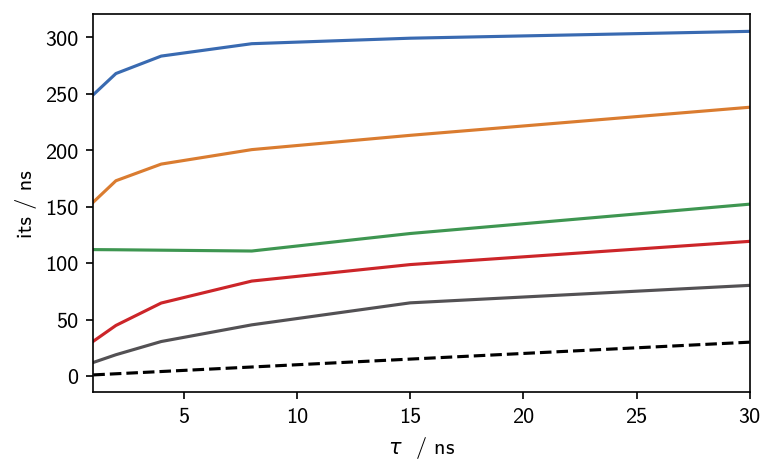

In [38]:
# Plot the time scales
fig, ax, *_ = M.plot_its()
fig.tight_layout(pad=0.1)

In [69]:
langerin.isolate()

In [76]:
langerin._children[1].data.points.cKDtree()
langerin._children[1].calc_neighbours_from_cKDTree(r=1)
langerin._children[1].fit(1, 5)

Execution time for call of fit: 0 hours, 0 minutes, 0.9313 seconds
--------------------------------------------------------------------------------
#points   R         N         M         max       #clusters %largest  %noise    
13233     1.000     5         2         None      3         0.725     0.001     
--------------------------------------------------------------------------------


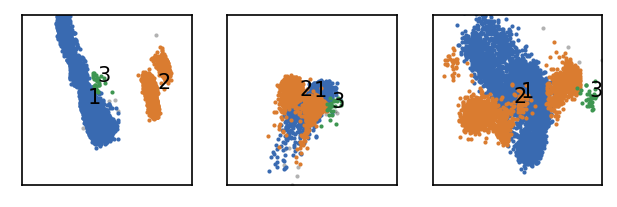

In [77]:
fig, Ax = plt.subplots(
    1, 3,
    figsize=(mpl.rcParams['figure.figsize'][0],
             mpl.rcParams['figure.figsize'][1]*0.5)
    )

for dim in range(3):
    _ = langerin._children[1].evaluate(
        ax=Ax[dim], plot="dots",
        ax_props=ax_props,
        dim=(dim*2, dim*2 + 1)
        )

<a name="space_a" />

## Space A

In [177]:
# Load the data
# 130 replica of holo-langerin;
# 100 ps time step;
# 5 dimensional TICA projection;
# 30 ns lag time, selected bb-dihedrals and H-bonds
proj = np.load('p30_5.npy', allow_pickle=True)
print(np.shape(proj), np.shape(proj[0]))

FileNotFoundError: [Errno 2] No such file or directory: 'p30_5.npy'

In [25]:
# optionally reduce dimensionality
# for i in range(len(proj)):
#     proj[i] = proj[i][:, :3]

In [115]:
# initialise clustering
langerin = cnn.CNN(test=proj)
langerin.cut(points=(None, None, 100))
print(langerin)

Configuration file found in /home/janjoswig
cnn.CNN cluster object
--------------------------------------------------------------------------------
alias :                                  root
hierachy level :                         0

test data shape :                        Parts      - 130
                                         Points     - [4002, 2501, 2201, 2201, 2201, '...']
                                         Dimensions - 5

train data shape :                       Parts      - 130
                                         Points     - [41, 26, 23, 23, 23, '...']
                                         Dimensions - 5

distance matrix calculated (train) :     False
distance matrix calculated (test) :      False
clustered :                              False
children :                               False
--------------------------------------------------------------------------------



<a name="clustering" />

### Clustering

Train distance matrix not calculated. Calculating distance matrix.


(<Figure size 975.192x602.669 with 1 Axes>,
 [Text(0.35896362584191055, 0.7247888035798966, '0.36'),
  Text(1.7948178889355477, 0.43464846777076316, '1.79'),
  Text(3.2306721520291855, 0.2663797558984762, '3.23'),
  Text(7.251064088691371, 0.050229576941857444, '7.25'),
  Text(11.271456025353556, 0.018509623274021017, '11.27')])

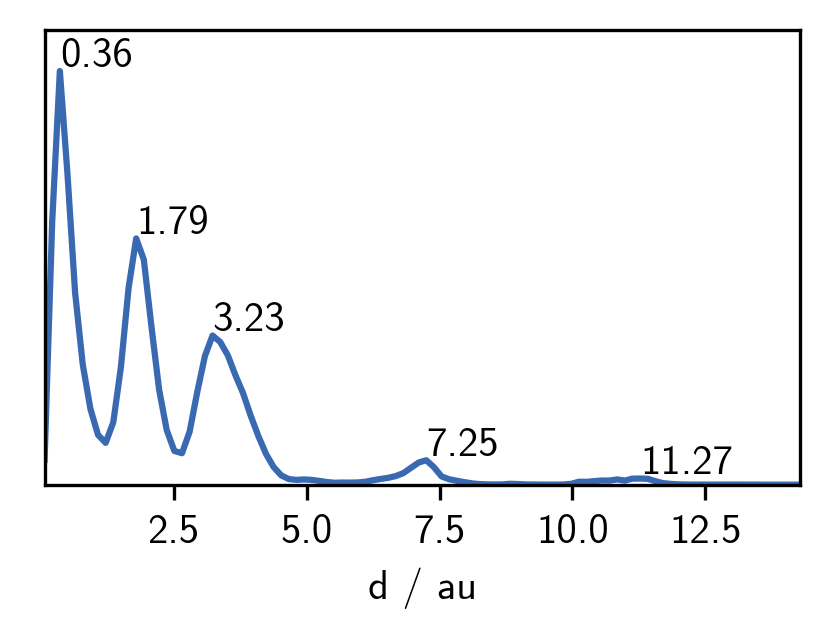

In [116]:
# Distance histogram
langerin.dist_hist(maxima=True, maxima_props={"order": 5})

In [118]:
# Axis property defaults for the following plots
ax_props2 = {
    "xlabel": None,
    "ylabel": None,
    "xticks": (),
    "yticks": (),
}

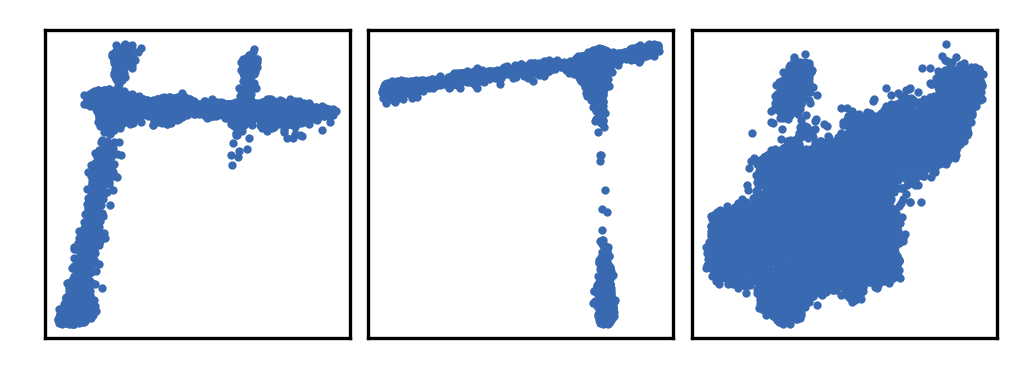

In [119]:
# Have a look at the original data ...
obj = langerin
fig, Ax = plt.subplots(1, 3, figsize=(6.50128*0.5, 6.50128*0.25*0.618*1.1))
obj.evaluate(ax=Ax[0], ax_props=ax_props2, mode="test", original=True)
obj.evaluate(ax=Ax[1], ax_props=ax_props2, dim=(1, 2), mode="test", original=True)
obj.evaluate(ax=Ax[2], ax_props=ax_props2, dim=(3, 4), mode="test", original=True)
fig.tight_layout(pad=0.1)

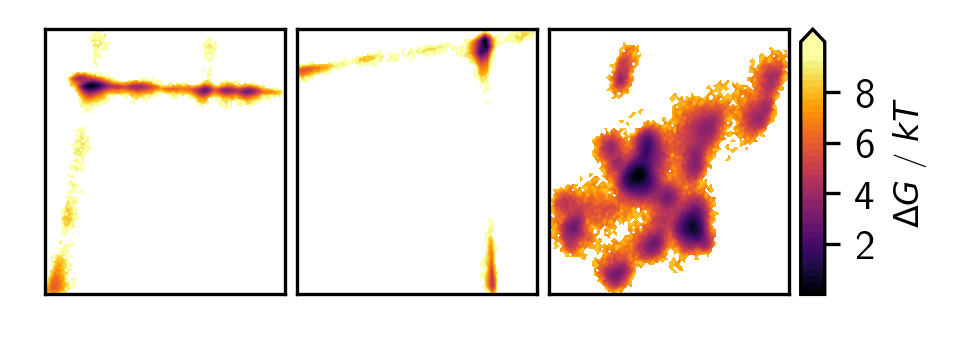

In [121]:
# Alternatively plot this as free energy landscape
obj = langerin
fig = plt.figure(figsize=(6.50128*0.5, 6.50128*0.2*0.618*1.1))
Ax = []
gspec = fig.add_gridspec(1, 22)
Ax.append(fig.add_subplot(gspec[0, :7]))
Ax.append(fig.add_subplot(gspec[0, 7:14]))
Ax.append(fig.add_subplot(gspec[0, 14:21]))
Ax.append(fig.add_subplot(gspec[0, -1]))
plotted = obj.evaluate(
    ax=Ax[0], ax_props=ax_props2,
    mode="test", original=True,
    plot='contourf', contour_props={"levels": 40, "vmin": 0, "vmax": 9.5, "extend": "max"}
    )[2]
obj.evaluate(
    ax=Ax[1], ax_props=ax_props2,
    dim=(1, 2),
    mode="test", original=True,
    plot='contourf', contour_props={"levels": 40, "vmin": 0, "vmax": 9.5}
    )
obj.evaluate(
    ax=Ax[2], ax_props=ax_props2,
    dim=(3, 4),
    mode="test", original=True,
    plot='contourf', contour_props={"levels": 40, "vmin": 0, "vmax": 9.5}
    )
# cbarax = fig.add_subplot(1, 20, 20)
cbar = fig.colorbar(mappable=plotted[0], cax=Ax[3], ticks=(2, 4, 6, 8))
cbar.set_label(r"$\Delta G$ / $kT$", fontsize=8)
fig.subplots_adjust(
    left=0, right=0.8, bottom=0, top=1, wspace=0.5, hspace=1 
    )

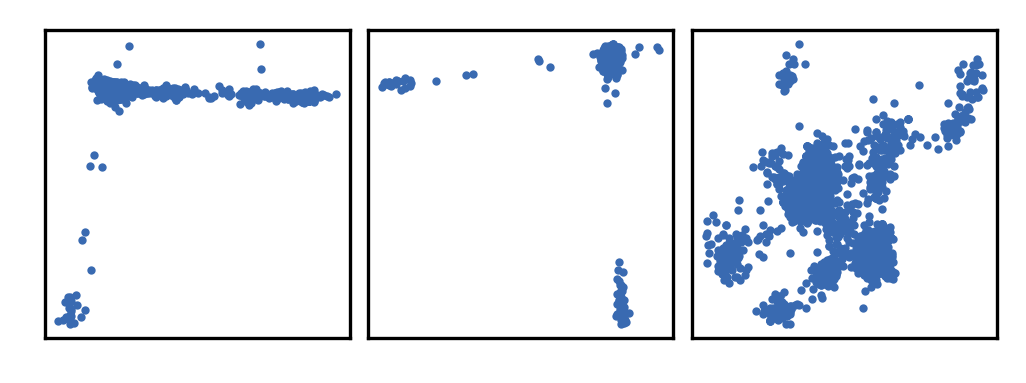

In [122]:
# ... and the reduced set
# Have a look at the original data
obj = langerin
fig, Ax = plt.subplots(1, 3, figsize=(6.50128*0.5, 6.50128*0.25*0.618*1.1))
obj.evaluate(ax=Ax[0], ax_props=ax_props2, original=True)
obj.evaluate(ax=Ax[1], ax_props=ax_props2, dim=(1, 2), original=True)
obj.evaluate(ax=Ax[2], ax_props=ax_props2, dim=(3, 4), original=True)
fig.tight_layout(pad=0.1)


-------------------------------------------------------------------------------
  #points     R     N     M     max     #clusters     %largest     %noise  
    3141      4.0    5     1    None         3         0.97453       0.0   
-------------------------------------------------------------------------------
Execution time for call of fit():     0 hours, 0 minutes, 2.0126 seconds
recording: ...


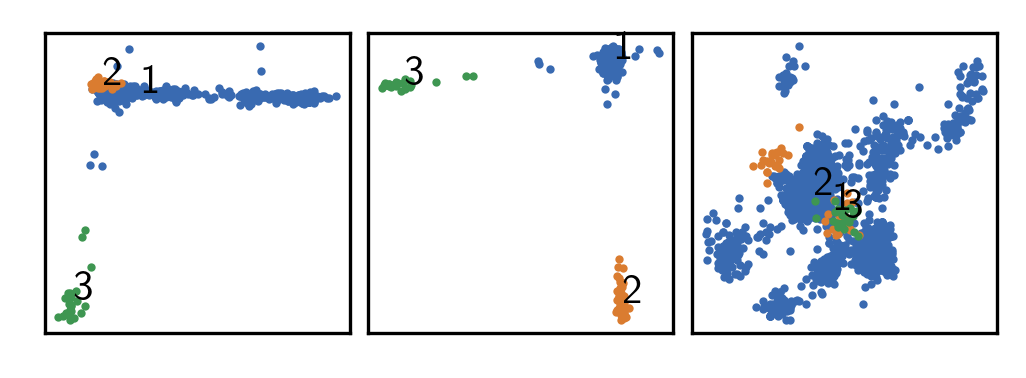

In [123]:
# Level 1
r, c = 4, 5
obj = langerin
obj.fit(radius_cutoff=r, cnn_cutoff=c)
fig, Ax = plt.subplots(1, 3, figsize=(6.50128*0.5, 6.50128*0.25*0.618*1.1))
obj.evaluate(ax=Ax[0], ax_props=ax_props2)
obj.evaluate(ax=Ax[1], ax_props=ax_props2, dim=(1, 2))
obj.evaluate(ax=Ax[2], ax_props=ax_props2, dim=(3, 4))
fig.tight_layout(pad=0.1)
# # fig.savefig(f"c_{r}_{c}.png")

In [124]:
# Isolate the result and prepare for level 2
langerin.isolate()
l1 = langerin.train_children[1]
l2 = langerin.train_children[2]
l3 = langerin.train_children[3]

Configuration file found in /home/janjoswig
Configuration file found in /home/janjoswig
Configuration file found in /home/janjoswig



-------------------------------------------------------------------------------
  #points     R     N     M     max     #clusters     %largest     %noise  
     24       1.0    0     1    None         2          0.875     0.041667 
-------------------------------------------------------------------------------
Execution time for call of fit():     0 hours, 0 minutes, 0.0056 seconds
recording: ...


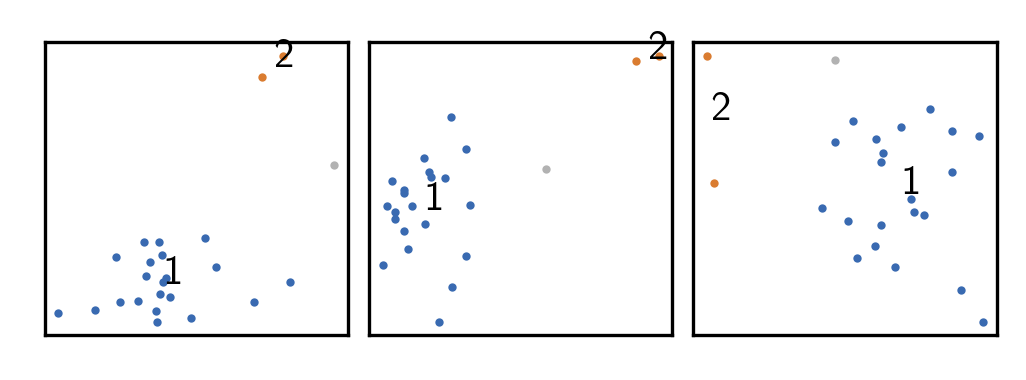

In [125]:
# Level 2, child 3
r, c = 1, 0
obj = l3
obj.fit(radius_cutoff=r, cnn_cutoff=c)
fig, Ax = plt.subplots(1, 3, figsize=(6.50128*0.5, 6.50128*0.25*0.618*1.1))
obj.evaluate(ax=Ax[0], ax_props=ax_props2)
obj.evaluate(ax=Ax[1], ax_props=ax_props2, dim=(1, 2))
obj.evaluate(ax=Ax[2], ax_props=ax_props2, dim=(3, 4))
fig.tight_layout(pad=0.1)
# # fig.savefig(f"c3_{r}_{c}.png")


-------------------------------------------------------------------------------
  #points     R     N     M     max     #clusters     %largest     %noise  
     56       0.8    5     1    None         2        0.553571    0.035714 
-------------------------------------------------------------------------------
Execution time for call of fit():     0 hours, 0 minutes, 0.0058 seconds
recording: ...


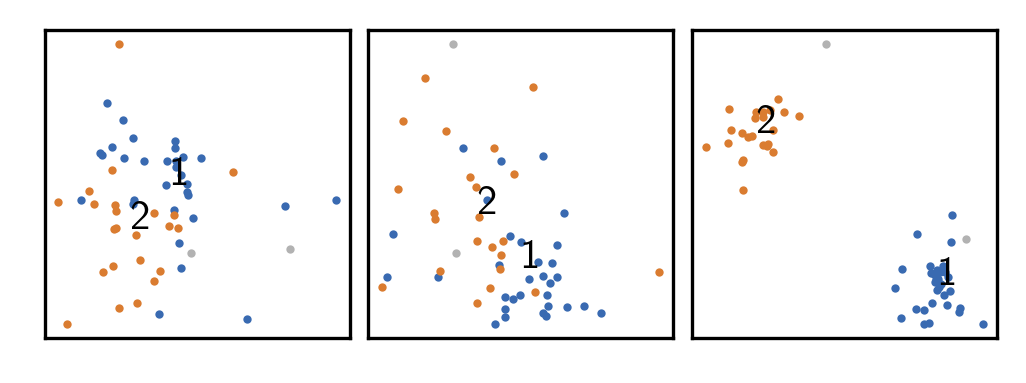

In [126]:
# Level 2, child 2
r, c = 0.8, 5
obj = l2
obj.fit(radius_cutoff=r, cnn_cutoff=c)
fig, Ax = plt.subplots(1, 3, figsize=(6.50128*0.5, 6.50128*0.25*0.618*1.1))
obj.evaluate(ax=Ax[0], ax_props=ax_props2)
obj.evaluate(ax=Ax[1], ax_props=ax_props2, dim=(1, 2))
obj.evaluate(ax=Ax[2], ax_props=ax_props2, dim=(3, 4))
fig.tight_layout(pad=0.1)
# # fig.savefig(f"c2_{r}_{c}.png")


-------------------------------------------------------------------------------
  #points     R     N     M     max     #clusters     %largest     %noise  
    3061      1.3    0     1    None         3        0.991833       0.0   
-------------------------------------------------------------------------------
Execution time for call of fit():     0 hours, 0 minutes, 1.2624 seconds
recording: ...


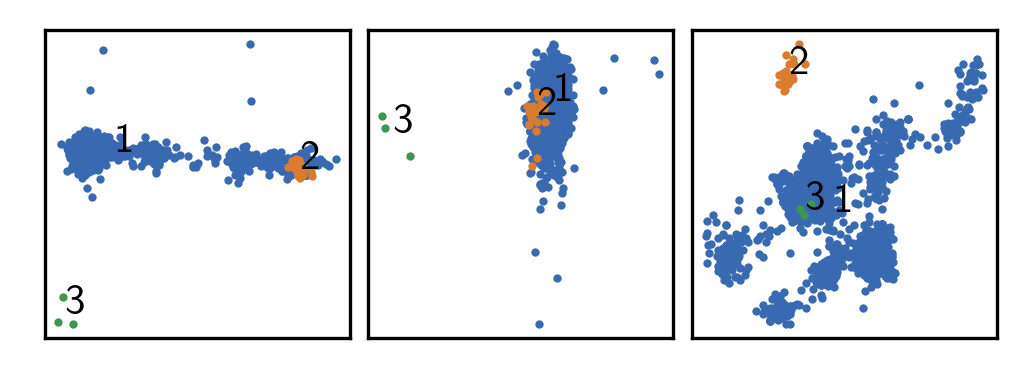

In [127]:
# Level 2, child 1
r, c = 1.3, 0
obj = l1
obj.fit(radius_cutoff=r, cnn_cutoff=c)
fig, Ax = plt.subplots(1, 3, figsize=(6.50128*0.5, 6.50128*0.25*0.618*1.1))
obj.evaluate(ax=Ax[0], ax_props=ax_props2)
obj.evaluate(ax=Ax[1], ax_props=ax_props2, dim=(1, 2))
obj.evaluate(ax=Ax[2], ax_props=ax_props2, dim=(3, 4))
fig.tight_layout(pad=0.1)
# # fig.savefig(f"c1_{r}_{c}.png")

In [128]:
# Isolate from l1 and prepare for level 3
l1.isolate()
l1_1 = l1.train_children[1]

Configuration file found in /home/janjoswig
Configuration file found in /home/janjoswig
Configuration file found in /home/janjoswig



-------------------------------------------------------------------------------
  #points     R     N     M     max     #clusters     %largest     %noise  
    3036      0.9    0     0    None         6        0.972661       0.0   
-------------------------------------------------------------------------------
Execution time for call of fit():     0 hours, 0 minutes, 1.1927 seconds
recording: ...


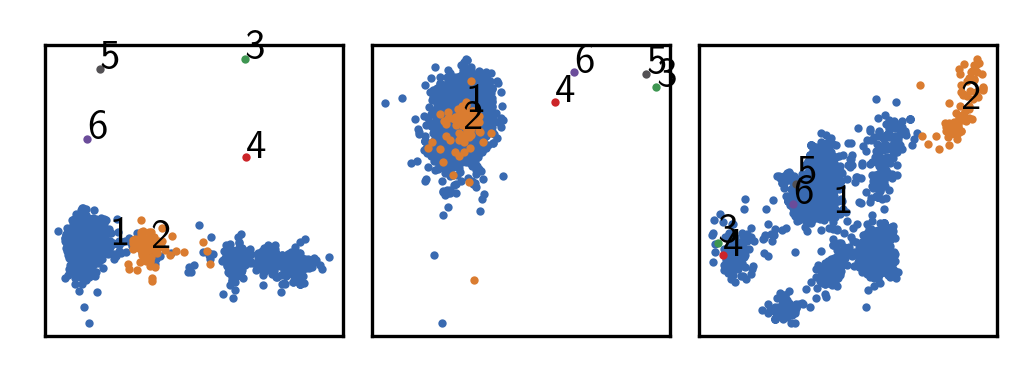

In [129]:
# Level 3, child 1
r, c = 0.9, 0
obj = l1_1
obj.fit(radius_cutoff=r, cnn_cutoff=c, member_cutoff=0)
fig, Ax = plt.subplots(1, 3, figsize=(6.50128*0.5, 6.50128*0.25*0.618*1.1))
obj.evaluate(ax=Ax[0], ax_props=ax_props2)
obj.evaluate(ax=Ax[1], ax_props=ax_props2, dim=(1, 2))
obj.evaluate(ax=Ax[2], ax_props=ax_props2, dim=(3, 4))
fig.tight_layout(pad=0.1)
# # fig.savefig(f"c1_1_{r}_{c}.png")

In [130]:
# Isolate from l1_1 and prepare for level 4
l1_1.isolate()
l1_1_1 = l1_1.train_children[1]

Configuration file found in /home/janjoswig
Configuration file found in /home/janjoswig
Configuration file found in /home/janjoswig
Configuration file found in /home/janjoswig
Configuration file found in /home/janjoswig
Configuration file found in /home/janjoswig



-------------------------------------------------------------------------------
  #points     R     N     M     max     #clusters     %largest     %noise  
    2953      0.6   10     1    None         4        0.850999    0.013207 
-------------------------------------------------------------------------------
Execution time for call of fit():     0 hours, 0 minutes, 0.8132 seconds
recording: ...


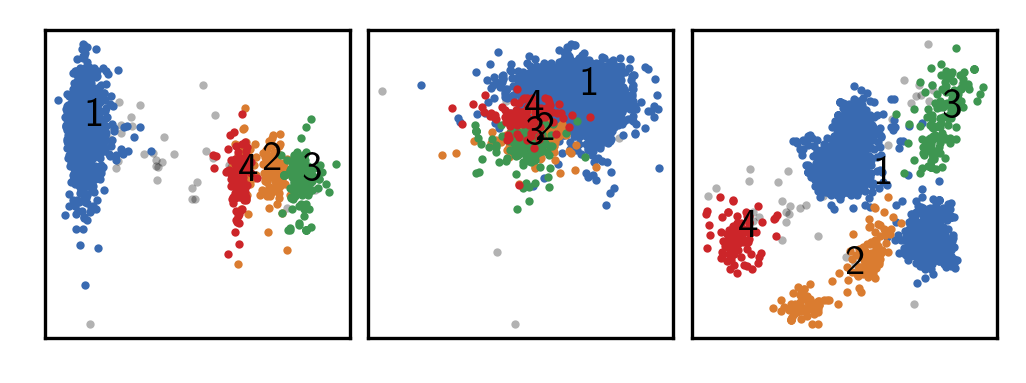

In [131]:
# Level 4, child 1
r, c = 0.6, 10
obj = l1_1_1
obj.fit(radius_cutoff=r, cnn_cutoff=c)
fig, Ax = plt.subplots(1, 3, figsize=(6.50128*0.5, 6.50128*0.25*0.618*1.1))
obj.evaluate(ax=Ax[0], ax_props=ax_props2)
obj.evaluate(ax=Ax[1], ax_props=ax_props2, dim=(1, 2))
obj.evaluate(ax=Ax[2], ax_props=ax_props2, dim=(3, 4))
fig.tight_layout(pad=0.1)
# # fig.savefig(f"c1_1_2_{r}_{c}.png")

In [132]:
# Isolate from l1_1_1 and prepare for level 5
l1_1_1.isolate()
l1_1_1_1 = l1_1_1.train_children[1]
l1_1_1_2 = l1_1_1.train_children[2]

Configuration file found in /home/janjoswig
Configuration file found in /home/janjoswig
Configuration file found in /home/janjoswig
Configuration file found in /home/janjoswig
Configuration file found in /home/janjoswig



-------------------------------------------------------------------------------
  #points     R     N     M     max     #clusters     %largest     %noise  
     158      0.4   15     1    None         2        0.525316    0.113924 
-------------------------------------------------------------------------------
Execution time for call of fit():     0 hours, 0 minutes, 0.0100 seconds
recording: ...


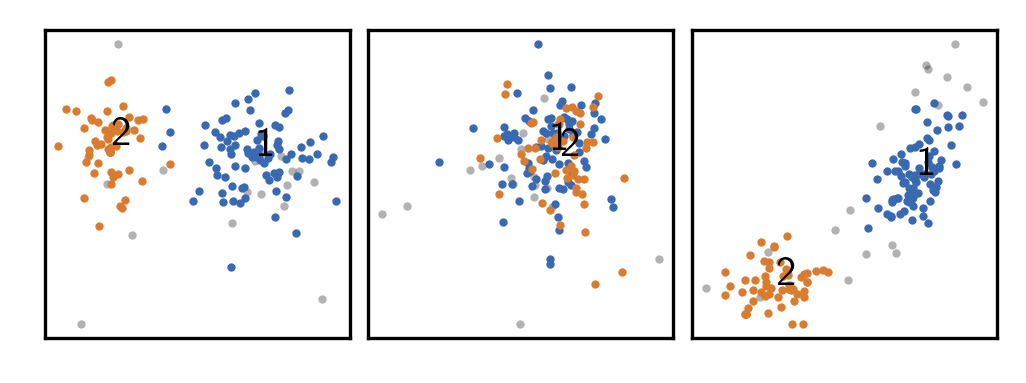

In [133]:
# Level 5, child 2
r, c = 0.4, 15
obj = l1_1_1_2
obj.fit(radius_cutoff=r, cnn_cutoff=c)
fig, Ax = plt.subplots(1, 3, figsize=(6.50128*0.5, 6.50128*0.25*0.618*1.1))
obj.evaluate(ax=Ax[0], ax_props=ax_props2)
obj.evaluate(ax=Ax[1], ax_props=ax_props2, dim=(1, 2))
obj.evaluate(ax=Ax[2], ax_props=ax_props2, dim=(3, 4))
fig.tight_layout(pad=0.1)
# # fig.savefig(f"c1_1_1_2_{r}_{c}.png")


-------------------------------------------------------------------------------
  #points     R     N     M     max     #clusters     %largest     %noise  
    2513      0.4   20     1    None         2        0.653402    0.024274 
-------------------------------------------------------------------------------
Execution time for call of fit():     0 hours, 0 minutes, 0.5373 seconds
recording: ...


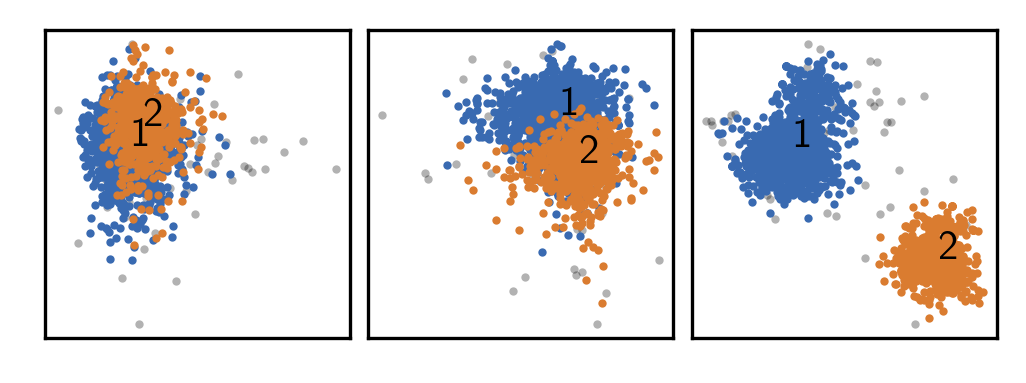

In [134]:
# Level 5, child 1
r, c = 0.4, 20
obj = l1_1_1_1
obj.fit(radius_cutoff=r, cnn_cutoff=c)
fig, Ax = plt.subplots(1, 3, figsize=(6.50128*0.5, 6.50128*0.25*0.618*1.1))
obj.evaluate(ax=Ax[0], ax_props=ax_props2)
obj.evaluate(ax=Ax[1], ax_props=ax_props2, dim=(1, 2))
obj.evaluate(ax=Ax[2], ax_props=ax_props2, dim=(3, 4))
fig.tight_layout(pad=0.1)
# # fig.savefig(f"c1_1_1_1_{r}_{c}.png")

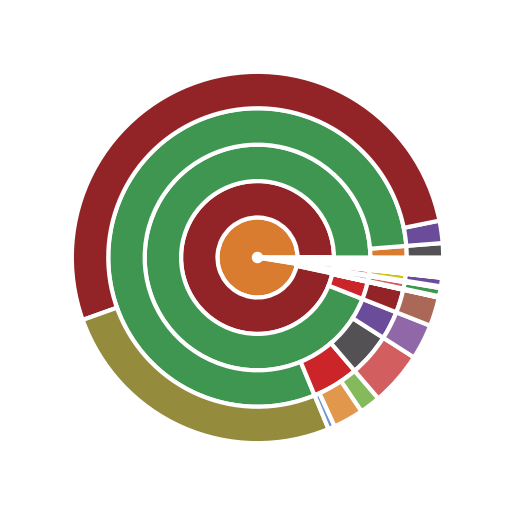

In [135]:
# Finished?
langerin.pie()

In [136]:
# Wrap up from child to parent
l1_1_1.reel()
l1_1.reel()
l1.reel()
langerin.reel()

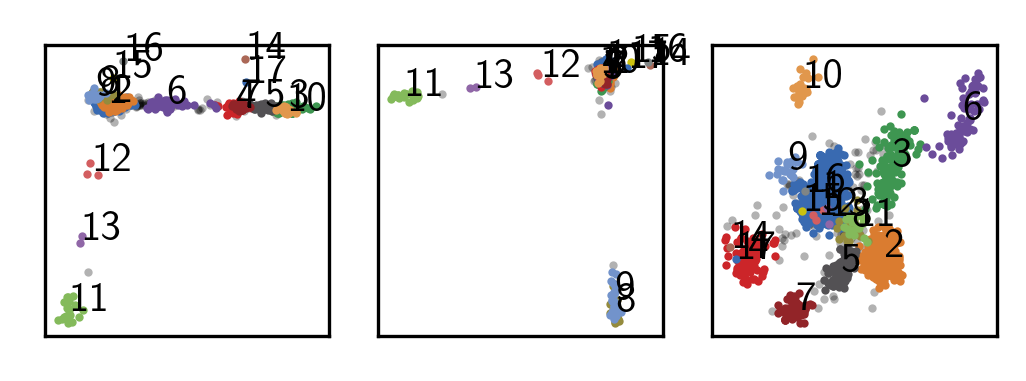

In [137]:
# Plot the total clustering result
obj = langerin
fig, Ax = plt.subplots(1, 3, figsize=(6.50128*0.5, 6.50128*0.25*0.618*1.1))
obj.evaluate(ax=Ax[0], ax_props=ax_props2)
obj.evaluate(ax=Ax[1], ax_props=ax_props2, dim=(1, 2))
obj.evaluate(ax=Ax[2], ax_props=ax_props2, dim=(3, 4))
fig.tight_layout(pad=0.1)
# # fig.savefig(f"c1_1_1_2_{r}_{c}.png")

In [138]:
# Cluster size overview
print(json.dumps({k: len(v) for k, v in langerin.train_clusterdict.items()}, indent=4))

{
    "0": 121,
    "1": 1642,
    "2": 810,
    "3": 147,
    "4": 96,
    "5": 83,
    "6": 79,
    "7": 57,
    "8": 31,
    "9": 23,
    "10": 22,
    "11": 21,
    "12": 3,
    "13": 2,
    "14": 1,
    "15": 1,
    "16": 1,
    "17": 1
}


In [405]:
# store train set assignments
# np.save("train_labels_30_5.npy", langerin.train_labels)

In [9]:
# load train set assignments
langerin.train_labels = np.load("train_labels_30_5.npy", allow_pickle=True)
# translate label information into clusterdict information
langerin.labels2dict()

In [10]:
# Prepare distance matrices for lookup
langerin.dist()
langerin.map()

In [ ]:
# Predict labels for the test set
# Going from small to large
langerin.predict(0.2, 0, clusters=[14, 15, 16, 17], behaviour="lookup")

In [ ]:
langerin.predict(0.5, 1, clusters=[12, 13], behaviour="lookup")

In [ ]:
langerin.predict(0.5, 5, clusters=[10, 11], behaviour="lookup")

In [ ]:
langerin.predict(0.4, 20, clusters=[1, 2], behaviour="lookup")

In [ ]:
langerin.predict(0.4, 10, clusters=[3, 4, 5, 6, 7, 8, 9], behaviour="lookup")

In [ ]:
# Plot the total clustering result
obj = langerin
fig, Ax = plt.subplots(1, 3, figsize=(6.50128*0.5, 6.50128*0.25*0.618*1.1))
obj.evaluate(ax=Ax[0], ax_props=axprops, mode="test")
obj.evaluate(ax=Ax[1], ax_props=axprops, dim=(1, 2), mode="test")
obj.evaluate(ax=Ax[2], ax_props=axprops, dim=(3, 4), mode="test")
fig.tight_layout(pad=0.1)
# # fig.savefig(f"c1_1_1_2_{r}_{c}.png")

<a name="cmsm" />

### Coreset MSM estimation

#### (MSM on train data *dt* = 10 ns)

In [18]:
# Create an MSM object
M = cmsm.CMSM(langerin.get_dtraj(mode='train'), unit="ns", step=10)

In [21]:
# Estimate csMSM for different lag times (given in steps)
lags = [1, 2, 3, 4]
for i in lags:
    M.cmsm(lag=i, minlenfactor=5)
    M.get_its()


*********************************************************
---------------------------------------------------------
Computing coreset MSM at lagtime 10 ns
---------------------------------------------------------

Trajectories [38]
are shorter then step threshold (lag*minlenfactor = 5)
and will not be used to compute the MSM.

Using 129 trajectories with 3126 steps over 17 coresets
---------------------------------------------------------
*********************************************************


*********************************************************
---------------------------------------------------------
Computing coreset MSM at lagtime 20 ns
---------------------------------------------------------

Trajectories [38]
are shorter then step threshold (lag*minlenfactor = 10)
and will not be used to compute the MSM.

Using 129 trajectories with 3126 steps over 17 coresets
---------------------------------------------------------
****************************************************

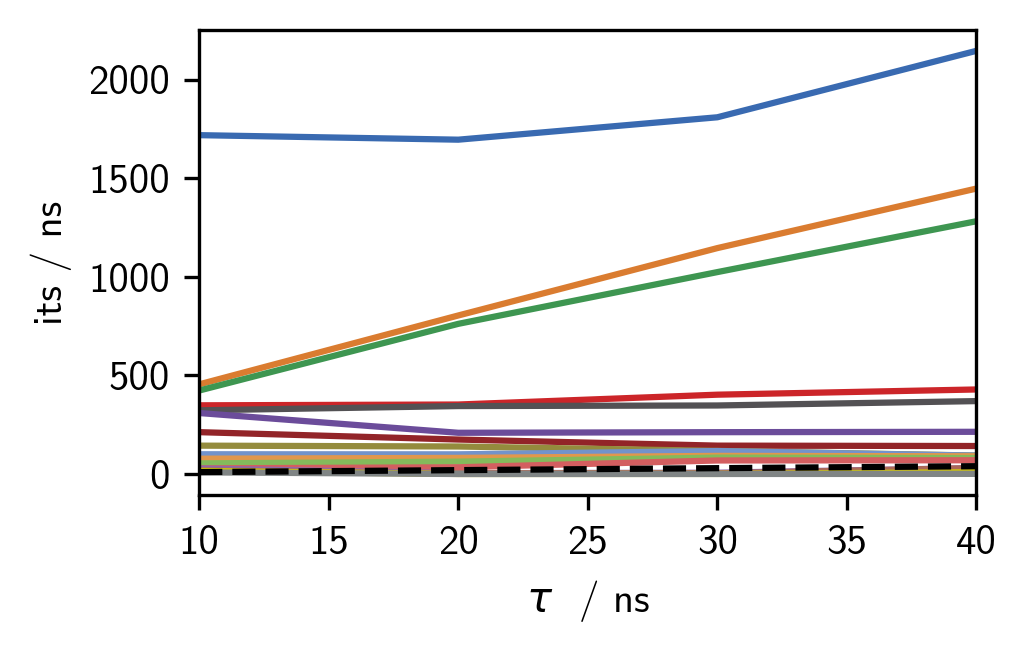

In [22]:
# Plot the time scales
fig, ax, *_ = M.plot_its()
fig.tight_layout(pad=0.1)

<a name="space_b" />

## Space B

In [139]:
# Load the data
# 130 replica of holo-langerin;
# 100 ps time step;
# 9 dimensional TICA projection;
# 9 ns lag time, selected bb-dihedrals and H-bonds
proj = np.load('p9_9.npy', allow_pickle=True)
print(np.shape(proj), np.shape(proj[0]))

(130,) (4002, 9)


In [140]:
# optionally reduce dimensionality
for i in range(len(proj)):
    proj[i] = proj[i][:, :3]

In [141]:
# initialise clustering
langerin_b = cnn.CNN(test=proj)
langerin_b.cut(points=(None, None, 100))
print(langerin_b)

Configuration file found in /home/janjoswig
cnn.CNN cluster object
--------------------------------------------------------------------------------
alias :                                  root
hierachy level :                         0

test data shape :                        Parts      - 130
                                         Points     - [4002, 2501, 2201, 2201, 2201, '...']
                                         Dimensions - 3

train data shape :                       Parts      - 130
                                         Points     - [41, 26, 23, 23, 23, '...']
                                         Dimensions - 3

distance matrix calculated (train) :     False
distance matrix calculated (test) :      False
clustered :                              False
children :                               False
--------------------------------------------------------------------------------



# [...]

<a name="clustering_b" />

### Clustering

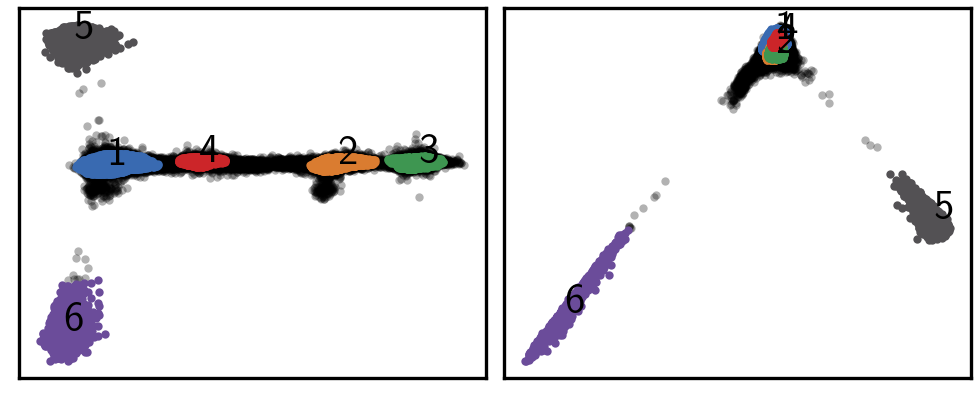

In [142]:
# You can also use this clustering and skip the prediction ...
Image("c_predicted_9_3.png")

In [143]:
# load train and test set assignments
langerin_b.train_labels = np.load("train_labels_9_3.npy", allow_pickle=True)
langerin_b.test_labels = np.load("test_labels_9_3.npy", allow_pickle=True)
# translate label information into clusterdict information
langerin_b.labels2dict()
langerin_b.labels2dict(mode="test")

<a name="cmsm_b" />

### Coreset MSM estimation

#### (MSM on test data *dt* = 0.1 ns)

In [144]:
# Create an MSM object
MB = cmsm.CMSM(langerin_b.get_dtraj(mode='test'), unit="ns", step=0.1)

In [145]:
# Estimate csMSM for different lag times (given in steps)
lags = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200, 250, 300]
for i in lags:
    MB.cmsm(lag=i, minlenfactor=5)
    MB.get_its()


*********************************************************
---------------------------------------------------------
Computing coreset MSM at lagtime 0.1 ns
---------------------------------------------------------

Using 130 trajectories with 301170 steps over 6 coresets
---------------------------------------------------------
*********************************************************


*********************************************************
---------------------------------------------------------
Computing coreset MSM at lagtime 1.0 ns
---------------------------------------------------------

Using 130 trajectories with 301170 steps over 6 coresets
---------------------------------------------------------
*********************************************************


*********************************************************
---------------------------------------------------------
Computing coreset MSM at lagtime 2.0 ns
---------------------------------------------------------

Traj

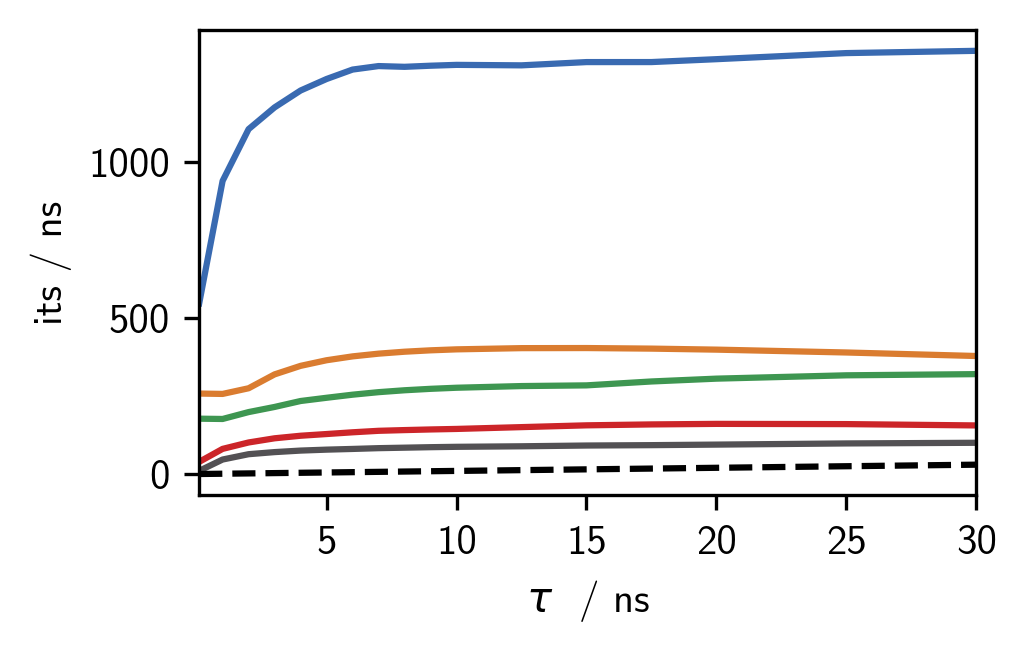

In [146]:
# Plot the implied time scales
fig, ax, *_ = MB.plot_its()
fig.tight_layout(pad=0.1)

In [147]:
# A Model at lag time 10 ns might be a good choice
MB.cmsm(lag=100)
MB.get_its()


*********************************************************
---------------------------------------------------------
Computing coreset MSM at lagtime 10.0 ns
---------------------------------------------------------

Trajectories [38]
are shorter then step threshold (lag*minlenfactor = 1000)
and will not be used to compute the MSM.

Using 129 trajectories with 301089 steps over 6 coresets
---------------------------------------------------------
*********************************************************



In [148]:
# Transition matrix
MB.T

array([[ 9.96803579e-01,  2.88007674e-04, -2.90934852e-07,
         1.85104164e-03,  7.84927156e-04,  2.72735582e-04],
       [ 2.67709646e-03,  9.68344445e-01,  2.16534956e-02,
         7.32579034e-03, -4.98370471e-08, -7.77422813e-07],
       [-7.50856852e-05,  3.43212694e-02,  9.52231599e-01,
         1.35221937e-02,  1.39780127e-09,  2.18047147e-08],
       [ 5.29790349e-02,  2.23999339e-02,  2.60014695e-02,
         8.98635933e-01, -9.86262053e-07, -1.53849930e-05],
       [ 3.47243911e-02,  1.40713811e-08, -1.42143962e-11,
        -6.79784120e-06,  9.65292477e-01, -1.00838853e-05],
       [ 2.44734782e-02,  9.91739893e-09, -1.00181948e-11,
        -4.79106511e-06, -4.55600275e-07,  9.75531759e-01]])

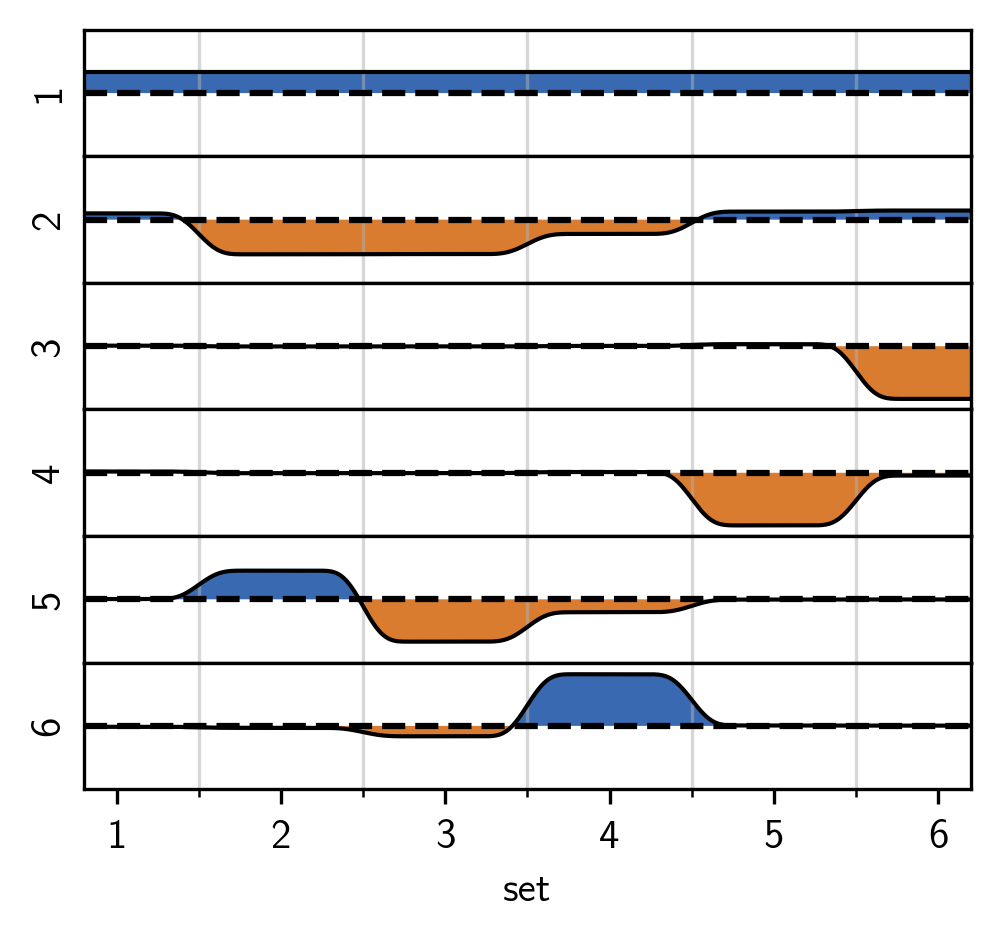

In [149]:
# You can plot the eigenvectors of the transition matrix (right)
mpl.rcParams['figure.figsize'] = 6.50128*0.5, 6.50128*0.5*0.618*1*0.25
fig, Ax = MB.plot_eigenvectors()
fig.subplots_adjust(
    left=0.08,
    bottom=0.15,
    right=0.99,
    top=0.99,
    wspace=None,
    hspace=0
    )

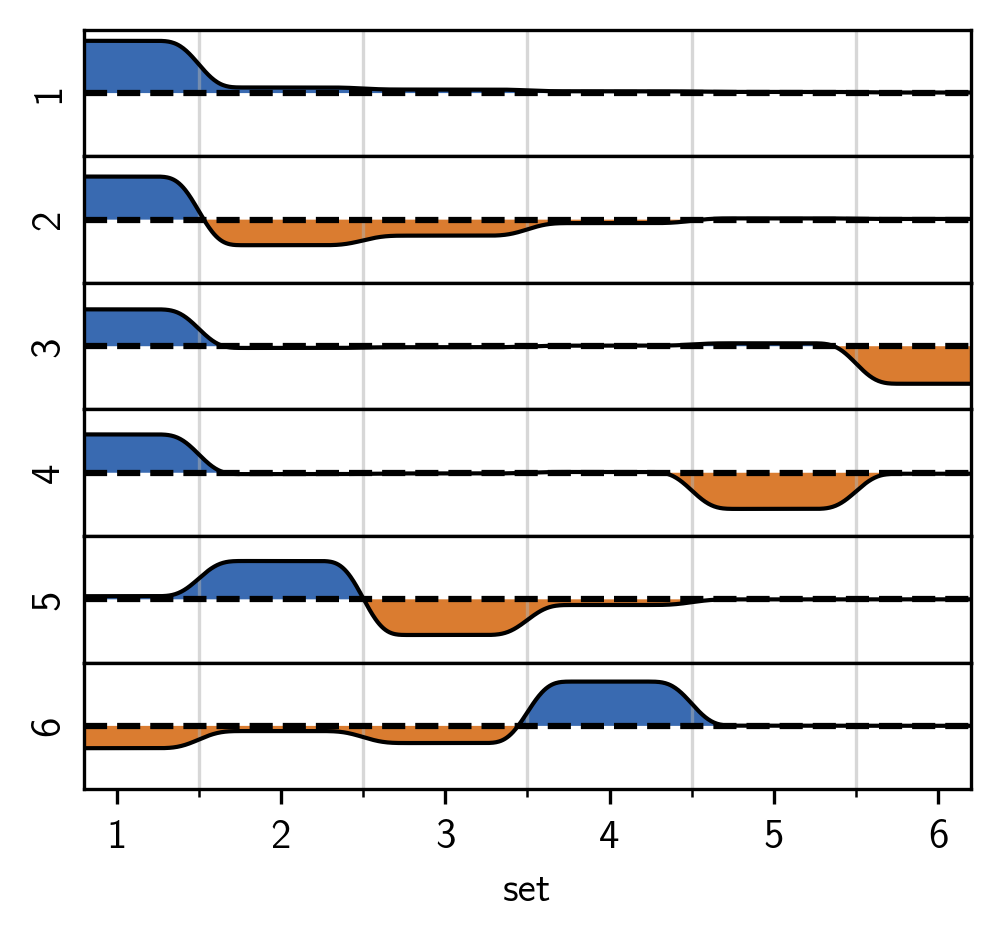

In [150]:
# You can plot the eigenvectors of the transition matrix (left)
mpl.rcParams['figure.figsize'] = 6.50128*0.5, 6.50128*0.5*0.618*1*0.25
fig, Ax = MB.plot_eigenvectors(which="left", invert=True)
fig.subplots_adjust(
    left=0.08,
    bottom=0.15,
    right=0.99,
    top=0.99,
    wspace=None,
    hspace=0
    )

<a name="benchmark" />

# Benchmark framework

In [ ]:
# Coming soon